In [44]:
from torchvision import models,transforms,datasets
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn as nn
from torch.autograd import Variable
import torch
import bcolz
import time
import torchvision
from utils import *
%matplotlib inline

In [45]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

prep1 = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])

In [46]:
data_dir = 'hymenoptera_data/'

dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), prep1)
         for x in ['train', 'val']}

dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=8,
                                               shuffle=False, num_workers=4)
                for x in ['train', 'val']}
dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_classes = dsets['train'].classes

use_gpu = torch.cuda.is_available()

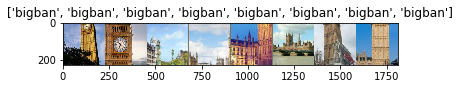

In [47]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dset_loaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[dset_classes[x] for x in classes])

In [48]:
model_vgg = models.vgg16(pretrained=True)
model_vgg = model_vgg.cuda()

In [49]:
for param in model_vgg.features.parameters():
    param.requires_grad = False

In [50]:
model_vgg.classifier[6].out_features = 2

In [51]:
criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer = torch.optim.SGD(model_vgg.classifier.parameters(),lr=lr)

In [52]:
%%time
train=True
for epoch in range(10):
        #batches = data_gen(conv_feat=conv_feat,labels=labels,shuffle=shuffle)
        total = 0
        running_loss = 0.0
        running_corrects = 0
        for inputs,classes in dset_loaders['train']:
            inputs , classes = Variable(inputs.cuda()),Variable(classes.cuda())
            #inputs = inputs.view(inputs.size(0), -1)
            outputs = model_vgg(inputs)
            loss = criterion(outputs,classes)           
            if train:
                if optimizer is None:
                    raise ValueError('Pass optimizer for train mode')
                optimizer = optimizer
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            _,preds = torch.max(outputs.data,1)
            # statistics
            running_loss += loss.data[0]
            running_corrects += torch.sum(preds == classes.data)
        epoch_loss = running_loss / dset_sizes['train']
        epoch_acc = running_corrects / dset_sizes['train']
        print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))

Loss: 0.1691 Acc: 0.8290
Loss: 0.0190 Acc: 0.9430
Loss: 0.0183 Acc: 0.9482
Loss: 0.0113 Acc: 0.9741
Loss: 0.0093 Acc: 0.9793
Loss: 0.0184 Acc: 0.9611
Loss: 0.0118 Acc: 0.9715
Loss: 0.0076 Acc: 0.9819
Loss: 0.0125 Acc: 0.9663
Loss: 0.0083 Acc: 0.9793
CPU times: user 1min 12s, sys: 31.5 s, total: 1min 44s
Wall time: 1min 45s


In [69]:
def visualize_model(model, num_images=300):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dset_loaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(1, 1, 1)
            #ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(dset_classes[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

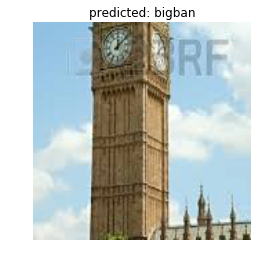

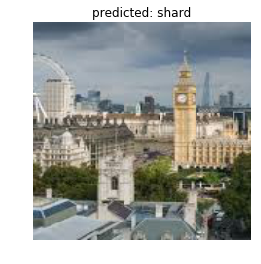

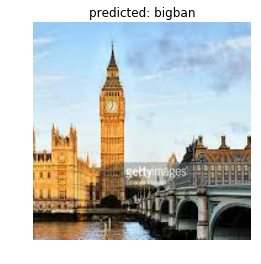

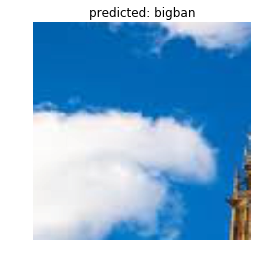

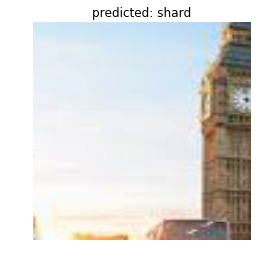

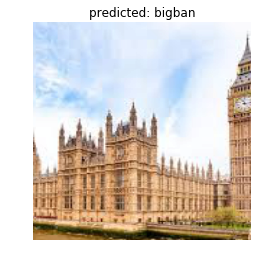

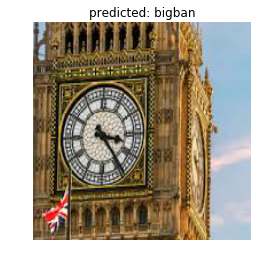

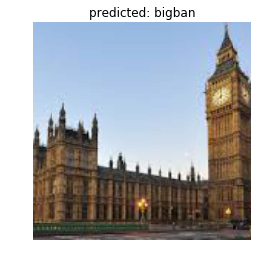

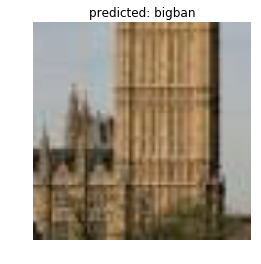

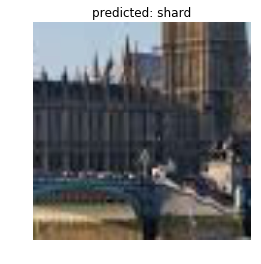

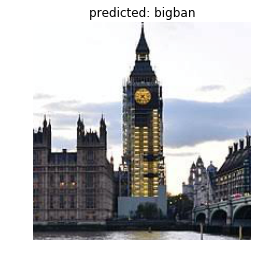

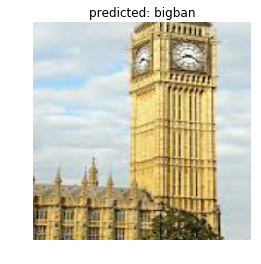

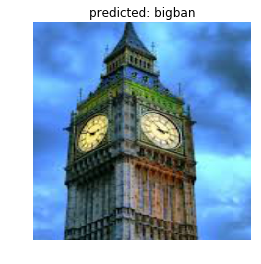

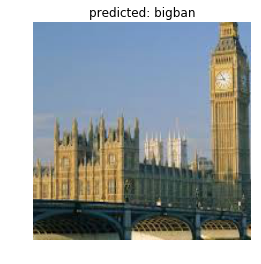

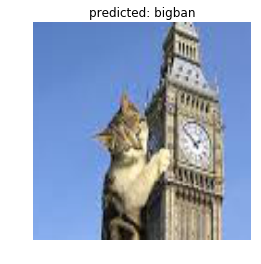

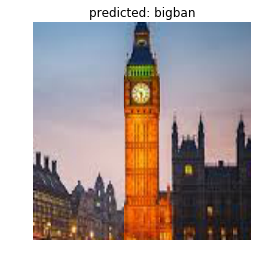

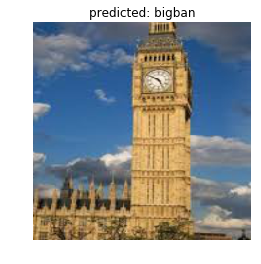

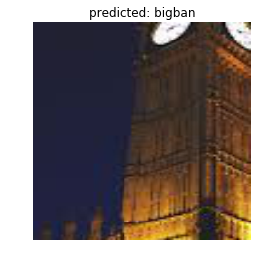

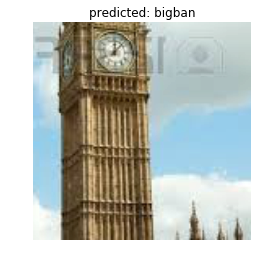

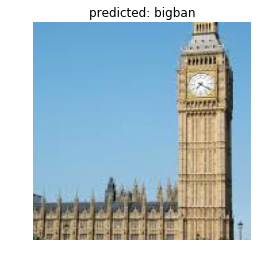

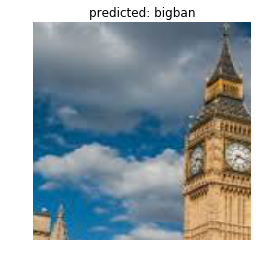

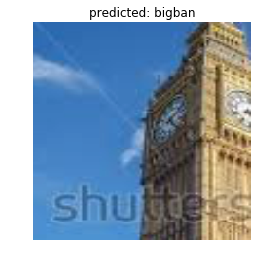

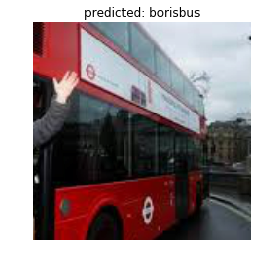

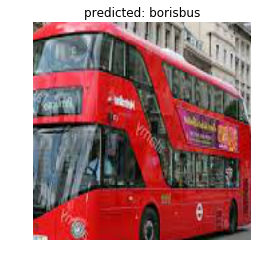

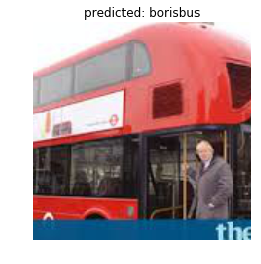

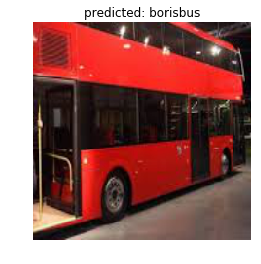

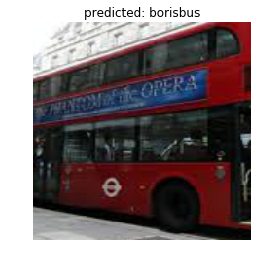

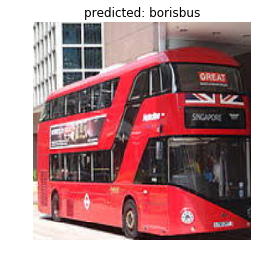

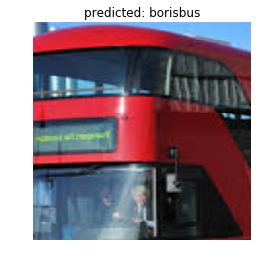

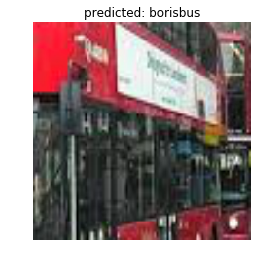

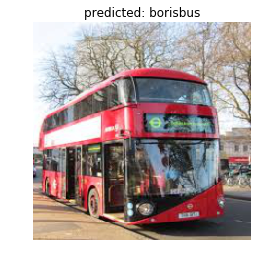

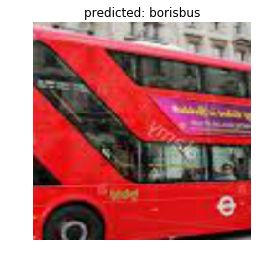

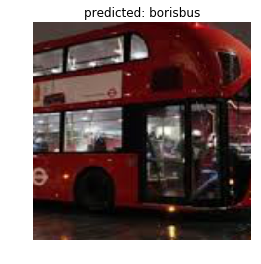

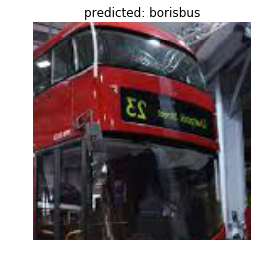

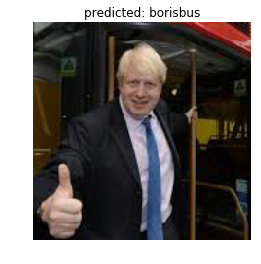

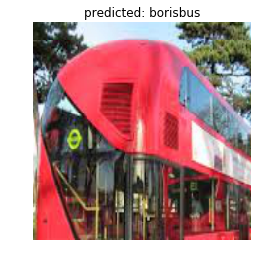

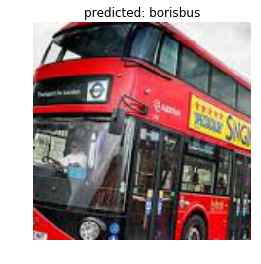

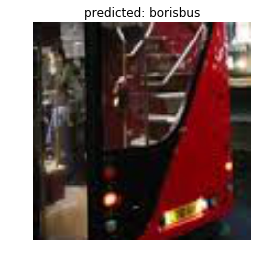

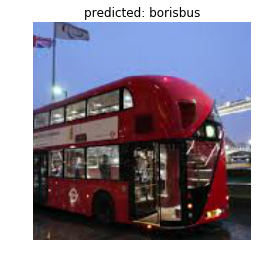

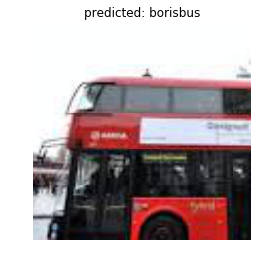

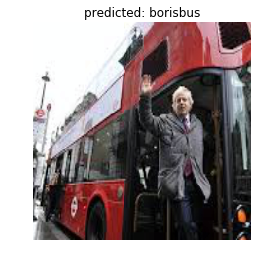

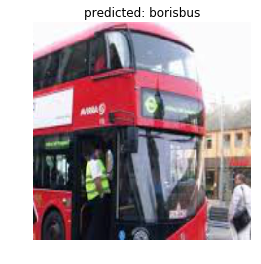

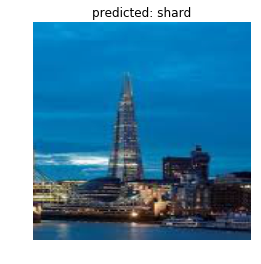

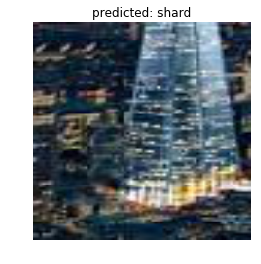

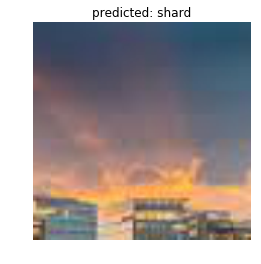

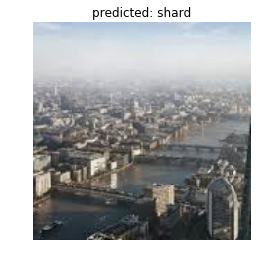

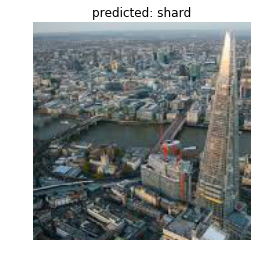

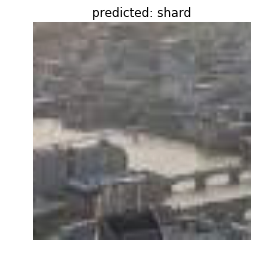

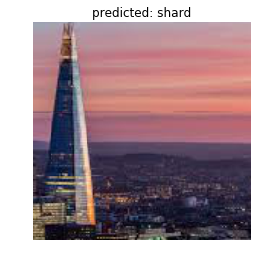

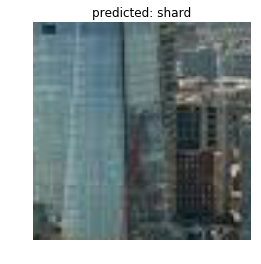

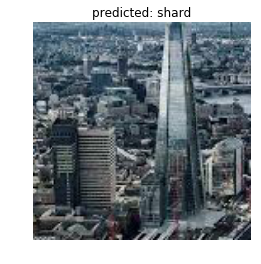

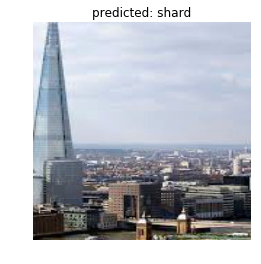

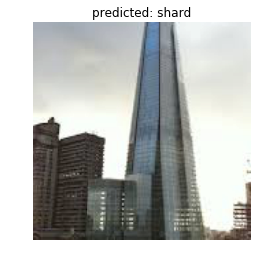

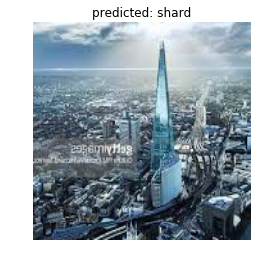

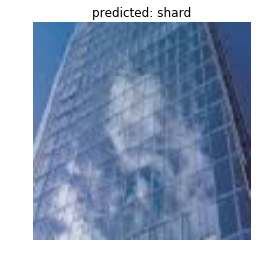

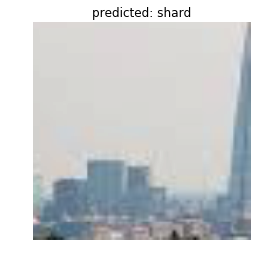

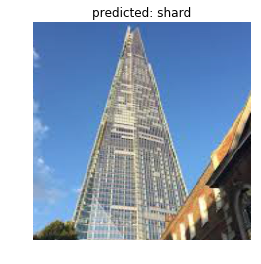

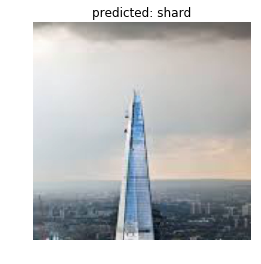

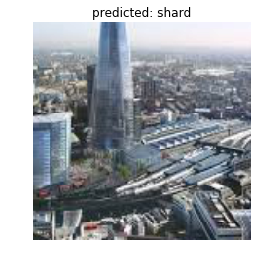

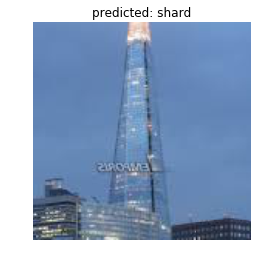

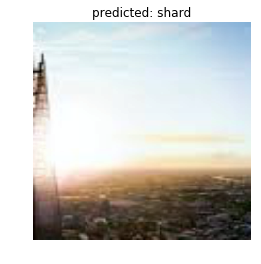

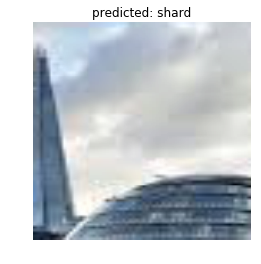

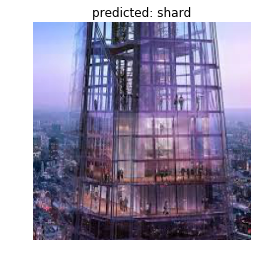

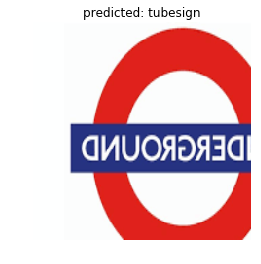

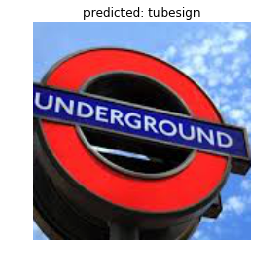

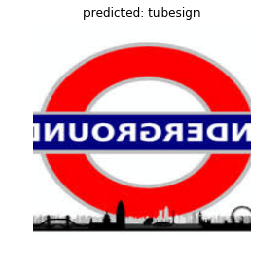

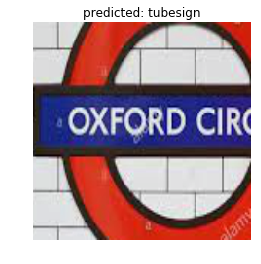

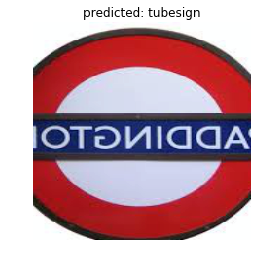

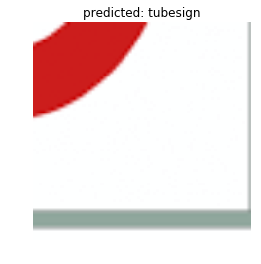

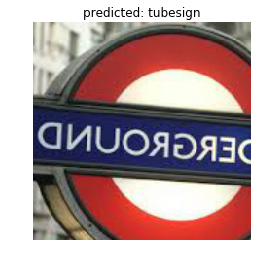

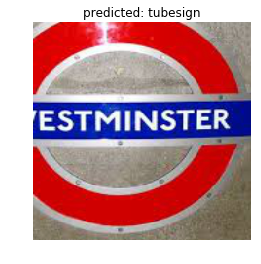

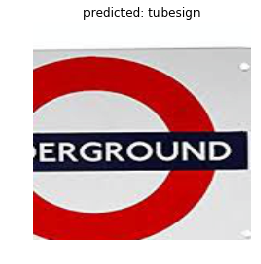

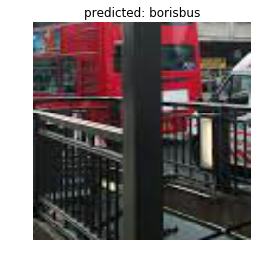

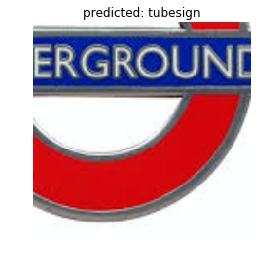

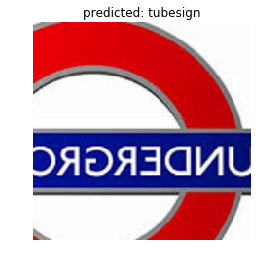

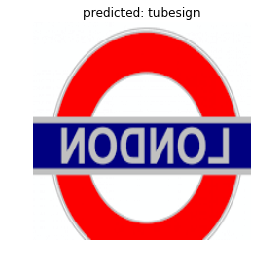

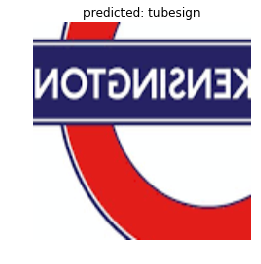

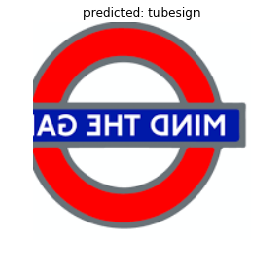

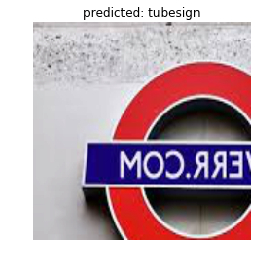

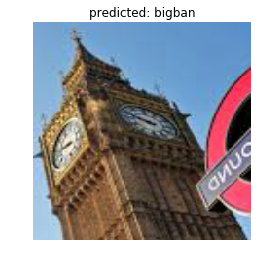

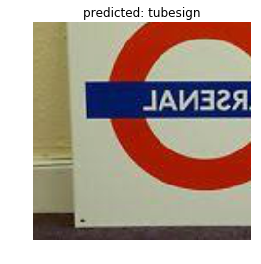

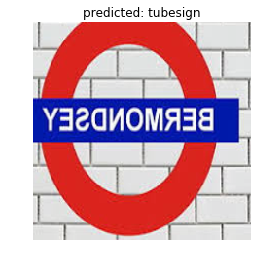

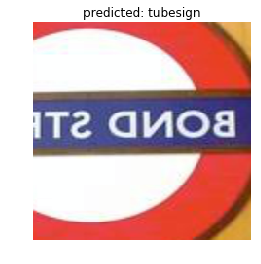

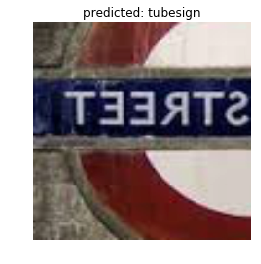

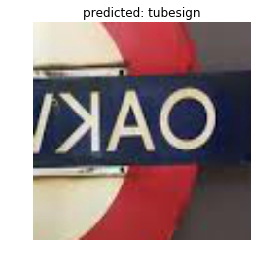

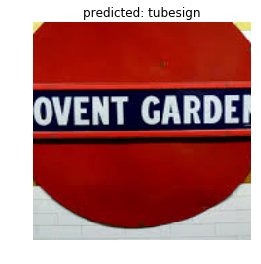

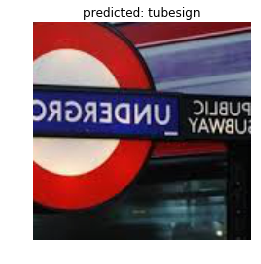

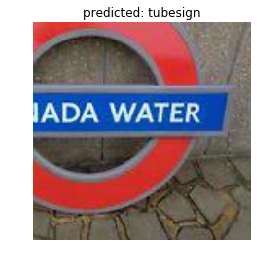

In [70]:
visualize_model(model_vgg)